/tmp/ipykernel_1840/1781761204.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range("2024-01-01 09:00:00", periods=num_candles, freq="15T")
/tmp/ipykernel_1840/1781761204.py:87: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


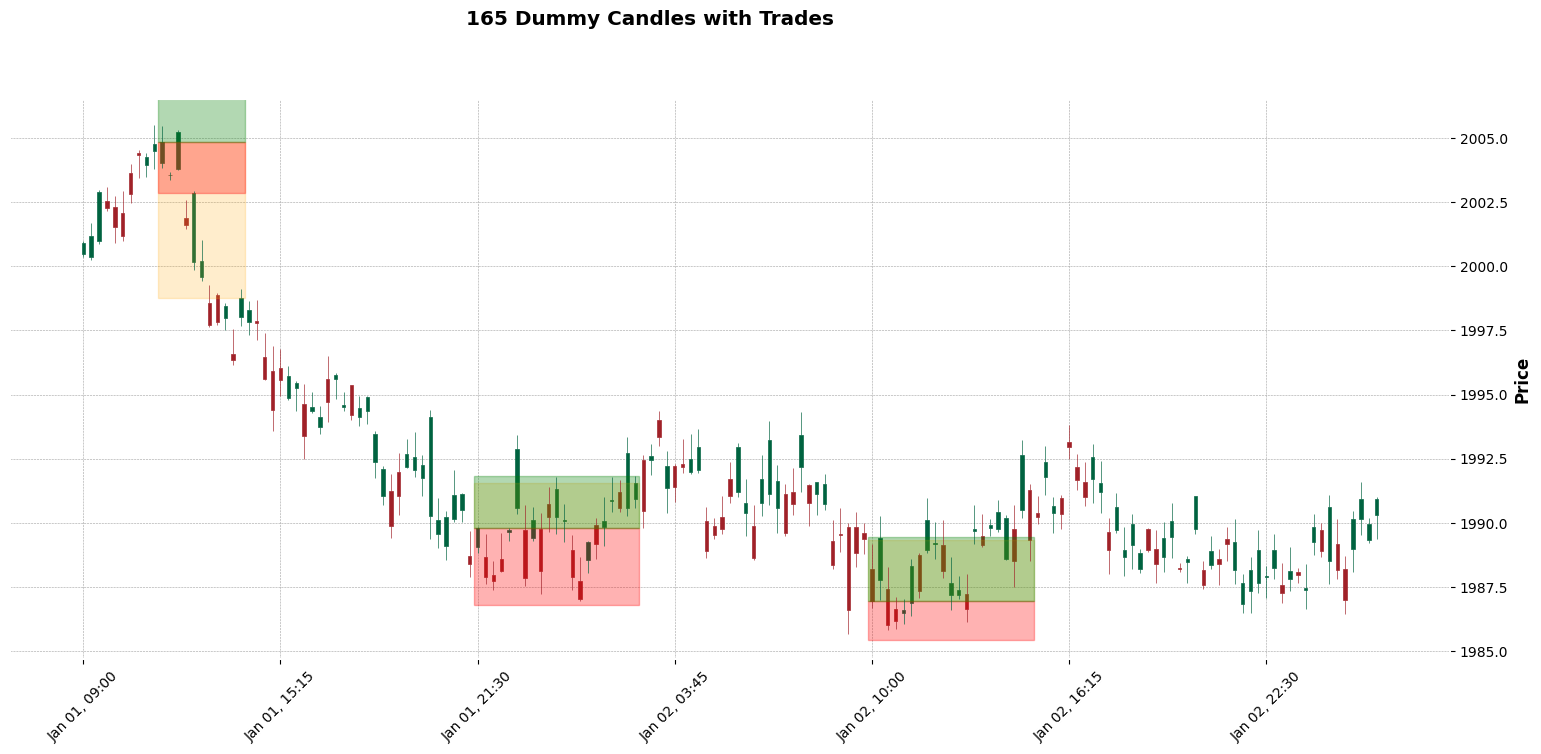

In [1]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.patches as patches

# ------------------------------
# 1. Generate dummy OHLC data
# ------------------------------
np.random.seed(42)
num_candles = 165
base_price = 2000

dates = pd.date_range("2024-01-01 09:00:00", periods=num_candles, freq="15T")
opens = base_price + np.random.randn(num_candles).cumsum()
closes = opens + np.random.randn(num_candles)
highs = np.maximum(opens, closes) + np.random.rand(num_candles)
lows = np.minimum(opens, closes) - np.random.rand(num_candles)
volumes = np.random.randint(10, 100, num_candles)

ohlc = pd.DataFrame({
    "Open": opens,
    "High": highs,
    "Low": lows,
    "Close": closes,
    "Volume": volumes
}, index=dates)

# ------------------------------
# 2. Dummy trades
# ------------------------------
trades = pd.DataFrame({
    "Trade ID": [1, 2, 3],
    "Entry Time": [dates[10], dates[50], dates[100]],
    "Exit Time": [dates[20], dates[70], dates[120]],
    "Entry Price": [ohlc["Close"].iloc[10], ohlc["Close"].iloc[50], ohlc["Close"].iloc[100]],
    "Exit Price": [ohlc["Close"].iloc[20], ohlc["Close"].iloc[70], ohlc["Close"].iloc[120]],
    "SL": [ohlc["Close"].iloc[10]-2, ohlc["Close"].iloc[50]-3, ohlc["Close"].iloc[100]-1.5],
    "TP": [ohlc["Close"].iloc[10]+3, ohlc["Close"].iloc[50]+2, ohlc["Close"].iloc[100]+2.5]
})

# ------------------------------
# 3. Function to create trade rectangles
# ------------------------------
def create_trade_rectangles(ohlc_df, trades_df):
    rectangles = []
    for _, trade in trades_df.iterrows():
        try:
            entry_idx = ohlc_df.index.get_loc(trade['Entry Time'])
            exit_idx = ohlc_df.index.get_loc(trade['Exit Time'])
        except KeyError:
            continue

        # Trade rectangle (orange)
        low = min(trade['Entry Price'], trade['Exit Price'])
        high = max(trade['Entry Price'], trade['Exit Price'])
        rectangles.append(patches.Rectangle((entry_idx-0.5, low), exit_idx-entry_idx+1, high-low, color='orange', alpha=0.2))

        # SL rectangle (red)
        if pd.notna(trade.get('SL')):
            rectangles.append(patches.Rectangle((entry_idx-0.5, min(trade['Entry Price'], trade['SL'])), exit_idx-entry_idx+1, abs(trade['Entry Price']-trade['SL']), color='red', alpha=0.3))

        # TP rectangle (green)
        if pd.notna(trade.get('TP')):
            rectangles.append(patches.Rectangle((entry_idx-0.5, min(trade['Entry Price'], trade['TP'])), exit_idx-entry_idx+1, abs(trade['Entry Price']-trade['TP']), color='green', alpha=0.3))

    return rectangles

# ------------------------------
# 4. Create rectangles
# ------------------------------
trade_rects = create_trade_rectangles(ohlc, trades)

# ------------------------------
# 5. Plot
# ------------------------------
fig, axlist = mpf.plot(
    ohlc,
    type='candle',
    style='charles',
    returnfig=True,
    figsize=(20,8),
    title='165 Dummy Candles with Trades'
)
ax = axlist[0]
for rect in trade_rects:
    ax.add_patch(rect)
fig.show()
